In [20]:
from matplotlib.pyplot import *
import numpy as np
from matplotlib import *
import h5py
from matplotlib import cm
from tqdm import tqdm
import pandas as pd
import sklearn
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter

# a. Useful Functions

In [21]:
def read_data_map(file,remove_baseline=False):

    hf = h5py.File(file, 'r')
    sample = file.split("\\")[-1]
    keys = [key for key in hf.keys()]
    sample = keys[0].split(' ')[-1]

    spectrums = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['Shot_0']['Pro']))) for i in range(0, #Pro sem baseline, raw com baseline
                                                        len(list(hf['Sample_ID: ' + sample])))])
    positions = np.array([np.ndarray.flatten(np.array(list(hf['Sample_ID: ' + sample]['Spot_' + str(i)]['position']))) for i in range(0,
                                                        len(list(hf['Sample_ID: ' + sample])))])
    wavelengths = np.array(hf['System properties']['wavelengths'])
    
    new_specs = []
        
    unique_x = np.unique(positions[:,0])
    unique_y = np.unique(positions[:,1])
    
    nx = len(unique_x)
    ny = len(unique_y)
    indexes = np.lexsort((positions[:,0],positions[:,1]))
    spectrums = spectrums[indexes,:]
    spectrums = np.array(spectrums.reshape((ny,nx,-1)))
    print(spectrums.shape)
    positions = np.array(positions[indexes])
    
    hf.close()
    return spectrums, wavelengths, positions

def Raman_data_loader(filename):

    with h5py.File( filename, 'a') as output_file:
         
        properties = output_file['properties']
        
        exp_properties = {'step_size' : np.array(properties['step_size'])[0],
                          'speed' : np.array(properties['speed']),
                          'n_points' : np.array(properties['n_points'])
            }
        
        wavelengths = np.array(output_file['properties']['x_data'])
        
        
        spot_numbers = [int(s.split('_')[-1]) for s in list(output_file['data'].keys()) if 'spot' in s ]
        
        Nx,Ny = output_file['properties']['n_points'][0], output_file['properties']['n_points'][1]
        Nl = len(wavelengths)
        spectral_signal = np.zeros([Nx,Ny,Nl])
        
        
        for _i, spot_number in enumerate(spot_numbers):

            ix, iy = int(spot_number//Ny), int(spot_number%Ny)
            
            spot = 'spot_'+str(spot_number)
            data = np.array(output_file['data'][spot]['raw_data'])
                      
            spectral_signal[ix,iy,:] = data
            

    return spectral_signal, wavelengths, exp_properties

In [22]:
find_index = lambda wavelenghts, w : np.argmin(np.abs(wavelenghts-w))

In [23]:
def gauss(x, sigma, val):
    return np.exp( - (x - val)**2 / (2 * sigma ** 2))

In [24]:
from scipy.ndimage import convolve

kernel = (1.0/256)*np.array([[1, 4, 6, 4, 1],[4, 16, 24, 16, 4],[6, 24, 36, 24, 6], [4, 16, 24, 16, 4],[1, 4, 6, 4, 1]])

def add_padding(data, x_pad, y_pad):
    return np.pad(data, ((0, 0), (x_pad , x_pad), (y_pad, y_pad)), mode = 'mean')

def downscale(image):
    image_blur = convolve(image, kernel, mode = 'constant')
    return image_blur[::2, ::2]  

def upscale(image):
    image_up = np.zeros((2*image.shape[0], 2*image.shape[1]))
    image_up[::2, ::2] = image
    return convolve(image_up, 4*kernel, mode = 'constant')

def laplacian_pyramid(image, layers):
    laplace_pyra = []
    for energy in range(image.shape[0]):
        im1 = image[energy]
        lap_pyra = []
        for layer in range(layers):
            down = downscale(im1)
            up = upscale(down)
            lap_pyra.append(im1 - up)
            im1 = down
        lap_pyra.append(down)
        laplace_pyra.append(lap_pyra)
    return np.array(laplace_pyra, dtype = object)

def gaussian_pyramid(mask, layers):
    gaussian_pyra = []
    for energy in range(mask.shape[0]):
        im1 = mask[energy]
        gauss_pyra = [im1]
        for layer in range(0, layers):
            im1 = downscale(im1)
            gauss_pyra.append(im1)
        gaussian_pyra.append(gauss_pyra)
    return np.array(gaussian_pyra, dtype = object)

def final_pyramid(L, G):
    laplacian_final = []
    for i in range(L.shape[1]):
        laplacian_final.append((L[0, i]*G[0, i] + L[1, i]*G[1, i] + L[2, i]*G[2, i]))
    return np.array(laplacian_final, dtype = object)

def get_image(final_pyramid):
    rev_pyramid = final_pyramid[::-1]
    im = rev_pyramid[0]
    for i in range(1, len(rev_pyramid)):
        im = upscale(im) + rev_pyramid[i]
    return im

# 1. Load LIBS Data for 3 Energies

In [25]:
fpath = "E:/Data/Data_LIBS/HDR/"
filename = ["rock2_340_map", "rock2_355_map", "rock2_370_map"]

spectrums = []
for fname in filename:
    spectrum, wavelengths, positions = read_data_map(fpath + fname)
    spectrums.append(spectrum)

(100, 110, 16384)
(100, 110, 16384)
(100, 110, 16384)


In [26]:
spectrums = np.array(spectrums)
wavelengths = wavelengths.flatten()

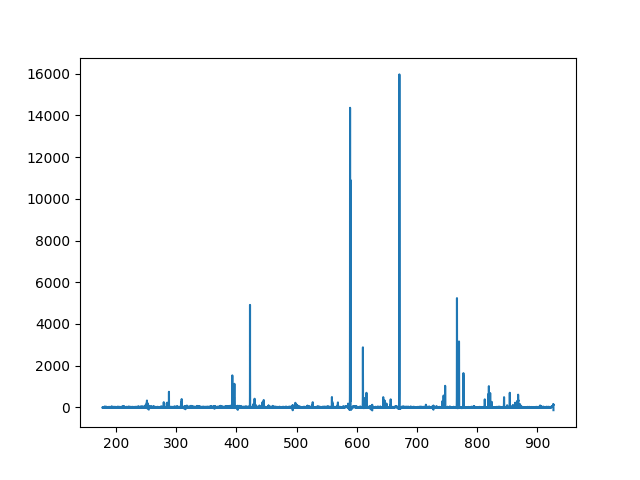

In [27]:
spec = 1 * spectrums[0, 25, 55, :]

%matplotlib widget
fig, ax = subplots()

ax.plot(wavelengths, spec)

In [28]:
pro_data = np.array(spectrums)

## 1.1 Normalize each spectrum to its sum 

In [29]:
pro_data_sum = np.array(pro_data)

for sp in range(pro_data_sum.shape[0]):
    spe = pro_data_sum[sp].reshape(pro_data_sum.shape[1]*pro_data_sum.shape[2], -1)
    norm = np.array([spe[i, :]/np.sum(spe[i, :]) for i in range(0, spe.shape[0])]).reshape(pro_data_sum.shape[1], pro_data_sum.shape[2], -1)
    print(norm.shape)
    pro_data_sum[sp] = norm

(100, 110, 16384)
(100, 110, 16384)
(100, 110, 16384)


## 1.2 Normalize each spectral image to [0-1] range | Gaussian smoothing

In [30]:
scaled_pro = []

sg = 0.5

for i in tqdm(range(0, pro_data_sum.shape[0])):
    # min_max_scaled = np.array([ (pro_data_sum[i, :, :, wv] - pro_data_sum[i].min())/(pro_data_sum[i].max() - pro_data_sum[i].min()) for wv in range(pro_data_sum.shape[-1])])
    min_max_scaled = np.array([ (gaussian_filter(pro_data_sum[i, :, :, wv], sigma = sg) - gaussian_filter(pro_data_sum[:, :, :, wv], sigma = sg).min())/
                                                (gaussian_filter(pro_data_sum[:, :, :, wv], sigma = sg).max() - gaussian_filter(pro_data_sum[:, :, :, wv], sigma = sg).min())
                               for wv in range(pro_data_sum.shape[-1])])
    scaled_pro.append(min_max_scaled)

scaled_pro = np.array(scaled_pro)

100%|██████████| 3/3 [06:18<00:00, 126.21s/it]


## 1.3 Find Translation to Assure proper alignment

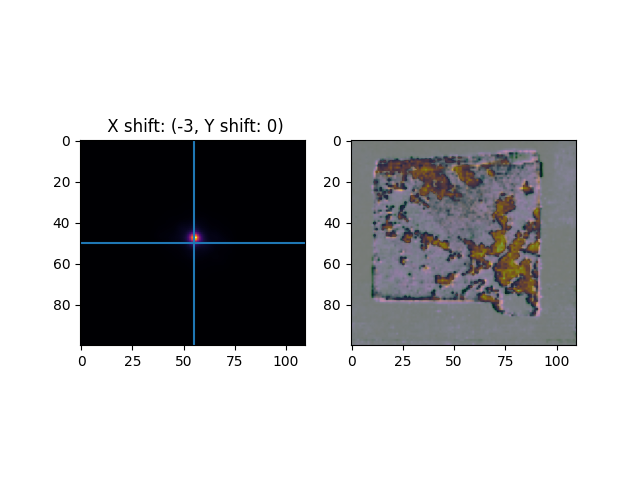

In [31]:
from scipy.signal import correlate

w_t = 819.4

im1 = scaled_pro[0, find_index(wavelengths, w_t)]
im2 = scaled_pro[2, find_index(wavelengths, w_t)]

translation = correlate(im1, im2, mode = 'same')**10

%matplotlib widget
fig, axs = subplots(1, 2)

cx = scaled_pro.shape[-2]//2
cy = scaled_pro.shape[-1]//2

shift_x = -(cx - np.where(translation == translation.max())[0][0])
shift_y = -(cy - np.where(translation == translation.max())[1][0])

ax = axs[0]
ax.set_title(f' X shift: ({shift_x}, ' 
             f'Y shift: {shift_y})')
ax.imshow(abs(translation), cmap = 'inferno')
ax.axhline(scaled_pro.shape[-2]//2)
ax.axvline(scaled_pro.shape[-1]//2)

ax = axs[1]
ax.imshow(im1, cmap = 'inferno')
ax.imshow(np.roll(im2, (shift_x, shift_y), axis = (0, 1)), alpha = 0.5, cmap = 'Greens', vmax = 0.2)

### 1.3.1 Set the transformation for all energies

In [32]:
for i in range(1, scaled_pro.shape[0]):
    im1 = scaled_pro[0, find_index(wavelengths, w_t)]
    im2 = scaled_pro[i, find_index(wavelengths, w_t)]

    translation = correlate(im1, im2, mode = 'same')**10

    cx = scaled_pro.shape[-2]//2
    cy = scaled_pro.shape[-1]//2

    shift_x = -(cx - np.where(translation == translation.max())[0][0])
    shift_y = -(cy - np.where(translation == translation.max())[1][0])
    scaled_pro[i] = np.roll(scaled_pro[i], (shift_x, shift_y), axis = (1, 2))

## 1.4 Find Rotation

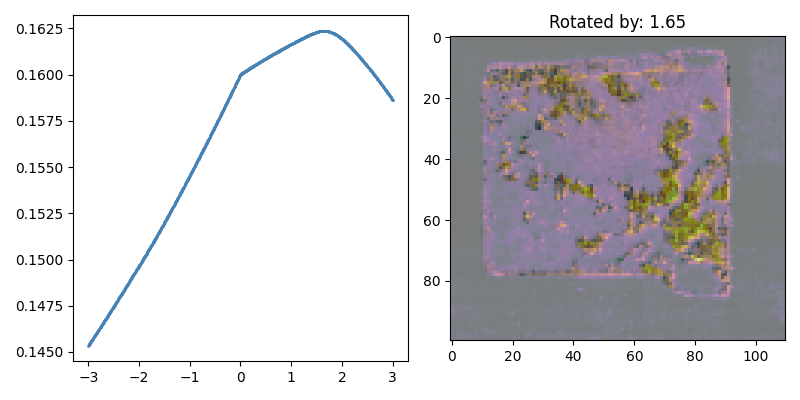

In [33]:
from scipy.signal import correlate
from skimage.transform import rotate

w_t = 819.4

im1 = scaled_pro[0, find_index(wavelengths, w_t)]
im2 = scaled_pro[2, find_index(wavelengths, w_t)]

max_angle = 3
rotation_angles = np.linspace(-max_angle, max_angle, 1000)
rot_coef = []

for i in rotation_angles:
    im2_rotated = rotate(im2, angle = i, resize = False)
    rot_coef.append( np.sum(im2_rotated*im1) / np.sqrt(np.sum(im2_rotated)**2 + np.sum(im1)**2))

angle_to_rot = rotation_angles[np.argmax(rot_coef)]

fig, axs = subplots(1, 2, figsize = (8, 4))

ax = axs[0]
ax.plot(rotation_angles, rot_coef, ls = '--', marker = 'o', color = 'steelblue', ms = 1)

ax = axs[1]
ax.set_title(f'Rotated by: {angle_to_rot:.2f}')
ax.imshow(im1, cmap = 'inferno')
ax.imshow(rotate(im2, angle = angle_to_rot, resize = False), alpha = 0.5, cmap = 'Greens', vmax = 0.5)

fig.tight_layout()

### 1.4.1 Set Rotation for All images

In [34]:
for i in range(1, scaled_pro.shape[0]):
    im1 = scaled_pro[0, find_index(wavelengths, w_t)]
    im2 = scaled_pro[i, find_index(wavelengths, w_t)]

    max_angle = 3
    rotation_angles = np.linspace(-max_angle, max_angle, 1000)
    rot_coef = []

    for a in rotation_angles:
        im2_rotated = rotate(im2, angle = a, resize = False)
        rot_coef.append( np.sum(im2_rotated*im1) / np.sqrt(np.sum(im2_rotated)**2 + np.sum(im1)**2))

    angle_to_rot = rotation_angles[np.argmax(rot_coef)]
    scaled_pro[i] = np.array([rotate(scaled_pro[i, j], angle = angle_to_rot, resize = False) for j in tqdm(range(scaled_pro[i].shape[0]))])

100%|██████████| 16384/16384 [00:11<00:00, 1440.32it/s]


# 2. Calculate Well-Exposedness Metric

In [35]:
w_exposedness = gauss(scaled_pro, 0.2, 0.5)
weights_norm = w_exposedness.copy()
w_sum = np.sum(w_exposedness, axis = 0)
weights_norm = w_exposedness/w_sum
            
weights_norm = np.array(weights_norm)

## 2.1 Pyramid Exposure Fusion

Note: Padding should be performed to each dimensions and is made to the closest base 2 number, e.g., 110 should be padded to 128, meaning total padding to 18 is necessary. X_padding should then be 9

In [36]:
new_data1 = np.zeros(scaled_pro.shape[1:])
n_layers = 6

# Padding deve ser numero de base 2 mais proximo, e.g., 110 passa a 128,
# padding é de 18, portanto x_padding seria 9

x_padding = 14
y_padding = 9

for j in tqdm(range(weights_norm.shape[1])):
    image_p = add_padding(scaled_pro[:, j], x_padding, y_padding)
    L = laplacian_pyramid(image_p, layers = n_layers)
    weights_p = add_padding(weights_norm[:, j], x_padding, y_padding)
    G = gaussian_pyramid(weights_p, layers = n_layers)
    final_pyra = final_pyramid(L, G)
    pyra_image = get_image(final_pyra)
    new_data1[j, :, :] = pyra_image[x_padding:pyra_image.shape[0]-x_padding, y_padding:pyra_image.shape[1]-y_padding]

  0%|          | 0/16384 [00:00<?, ?it/s]

100%|██████████| 16384/16384 [03:04<00:00, 88.59it/s] 


Text(-0.02, 0.5, 'y (mm)')

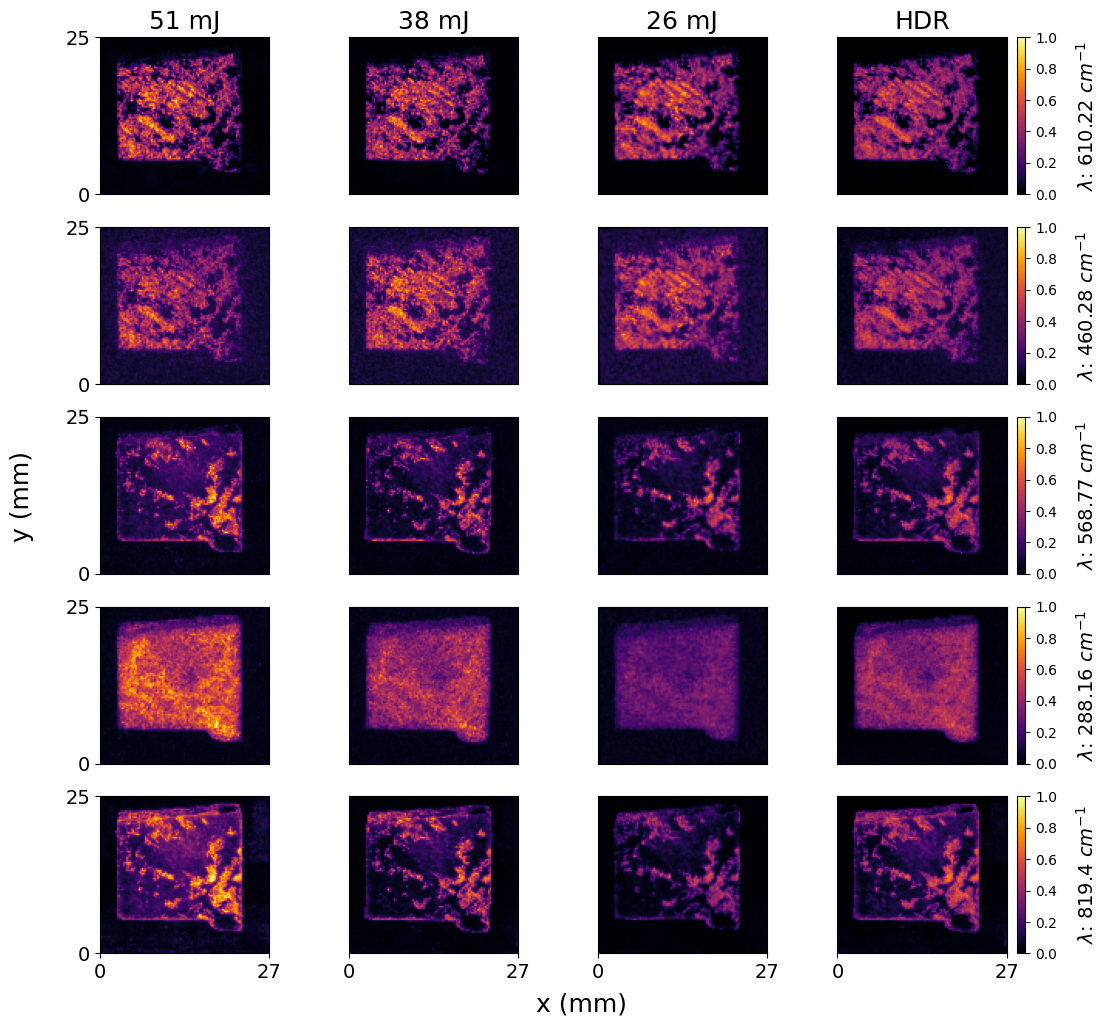

In [38]:
%matplotlib inline

%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = subplots(5, 4, figsize = (11, 10))

wl = [610.22, 460.28, 568.77, 288.16, 819.40]


for w in range(len(wl)):
    axs = ax[w, 0]
    if w == 0:
        axs.set_title('51 mJ', fontsize = 18)
    axs.imshow(scaled_pro[0, find_index(wavelengths, wl[w])], extent = (0, 27, 0, 25), cmap = 'inferno', vmin = 0, vmax = 1)
    axs.set_xticks([])
    axs.set_yticks([])

    axs = ax[w, 1]
    if w == 0:
        axs.set_title('38 mJ', fontsize = 18)
    axs.imshow(scaled_pro[1, find_index(wavelengths, wl[w])], extent = (0, 27, 0, 25), cmap = 'inferno', vmin = 0, vmax = 1)
    axs.set_xticks([])
    axs.set_yticks([])

    axs = ax[w, 2]
    if w == 0:
        axs.set_title('26 mJ', fontsize = 18)
    axs.imshow(scaled_pro[2, find_index(wavelengths, wl[w])], extent = (0, 27, 0, 25), cmap = 'inferno', vmin = 0, vmax = 1)
    axs.set_xticks([])
    axs.set_yticks([])

    axs = ax[w, 3]
    if w == 0:
        axs.set_title('HDR', fontsize = 18)
    im = axs.imshow(new_data1[find_index(wavelengths, wl[w])], extent = (0, 27, 0, 25), cmap = 'inferno', vmin = 0, vmax = 1)
    axs.set_xticks([])
    axs.set_yticks([])
    axs.set_ylabel(r'$\lambda$: ' + f'{wl[w]} ' + r'$cm^{-1}$', fontsize = 14, labelpad = 50)
    divider = make_axes_locatable(axs)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    colorbar(im, cax = cax)
    axs.yaxis.set_label_position("right")

for i in range(ax.shape[0]):
    ax[i, 0].set_yticks([0, 25])
    ax[i, 0].set_yticklabels([0, 25], fontsize = 14)
    
for j in range(ax.shape[1]):
    ax[-1, j].set_xticks([0, 27])
    ax[-1, j].set_xticklabels([0, 27], fontsize = 14)


fig.tight_layout(pad = 1)
fig.supxlabel('x (mm)', fontsize = 18, x = 0.5, y = -0.02)
fig.supylabel('y (mm)', fontsize = 18, y = 0.5, x = -0.02)

# fig.savefig('libs_energies.jpg', dpi = 300)

# 3. Raman Load

In [39]:
from scipy import sparse
from scipy.sparse.linalg import spsolve

def baseline_als_optimized(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

In [210]:
fpath = "E:/Data/Data_Raman/HDR/Quadrado/"
filename = ["20231211_ 927.h5", "20231211_1046.h5", "20231211_1152.h5"]

raman_spectrums = []
for fname in filename:
    spectrum_raman, wavelengths_raman, exp_properties = Raman_data_loader(fpath + fname)
    raman_spectrums.append(spectrum_raman)
raman_spectrums = np.array(raman_spectrums)

In [211]:
raman_spectrums = raman_spectrums[:, :, :, 31:328]
raman_wavelengths = np.array(wavelengths_raman[31:328])

## 3.1 Preprocess Raman Data -> Baseline Removal | Scale to [0-1] | Normalize to Sum

In [212]:
lam = 1e2
p = 1e-1

processed = np.array(raman_spectrums)

for k in range(0, processed.shape[0]):
    for i in tqdm(range(0, processed.shape[1])):
        for j in range(0, processed.shape[2]):
            spec = 1 * processed[k, i,j, :]
            processed[k,i,j,:] = spec - baseline_als_optimized(spec, lam = lam, p = p, niter = 10)

for sp in range(processed.shape[0]):
    spe = processed[sp].reshape(processed.shape[1]*processed.shape[2], -1)
    norm = np.array([spe[i, :]/np.sum(spe[i, :]) for i in range(0, spe.shape[0])]).reshape(processed.shape[1], processed.shape[2], -1)
    processed[sp] = norm

scaled_pro_raman = []
for i in range(0, processed.shape[0]):
    min_max_scaled = np.array([ (processed[i, :, :, wv] - processed[:, :, :, wv].min())/(processed[:, :, :, wv].max() - processed[:, :, :, wv].min()) 
                               for wv in range(processed.shape[-1])])
    scaled_pro_raman.append(min_max_scaled)

scaled_pro_raman = np.array(scaled_pro_raman)[:,:,0:64,0:64]

100%|██████████| 65/65 [00:41<00:00,  1.56it/s]


## 3.2 Pyramid Fusion Raman

In [214]:
w_exposedness = gauss(scaled_pro_raman, 0.2, 0.5)
weights_norm = w_exposedness.copy()
w_sum = np.sum(w_exposedness, axis = 0)
weights_norm = w_exposedness/w_sum
            
weights_norm = np.array(weights_norm)

new_data1_raman = np.zeros(scaled_pro_raman.shape[1:])
n_layers = 6

x_padding = 0
y_padding = 0

for j in tqdm(range(weights_norm.shape[1])):
    image_p = add_padding(scaled_pro_raman[:, j], x_padding,y_padding)
    L = laplacian_pyramid(image_p, layers = n_layers)
    weights_p = add_padding(weights_norm[:, j], x_padding,y_padding)
    G = gaussian_pyramid(weights_p, layers = n_layers)
    final_pyra = final_pyramid(L, G)
    pyra_image = get_image(final_pyra)
    new_data1_raman[j, :, :] = pyra_image[x_padding:pyra_image.shape[0]-x_padding, y_padding:pyra_image.shape[1]-y_padding]

100%|██████████| 297/297 [00:01<00:00, 181.70it/s]


## 3.3 Align with Final LIBS Pyramid

In [45]:
%load_ext autoreload

In [190]:
%autoreload 2

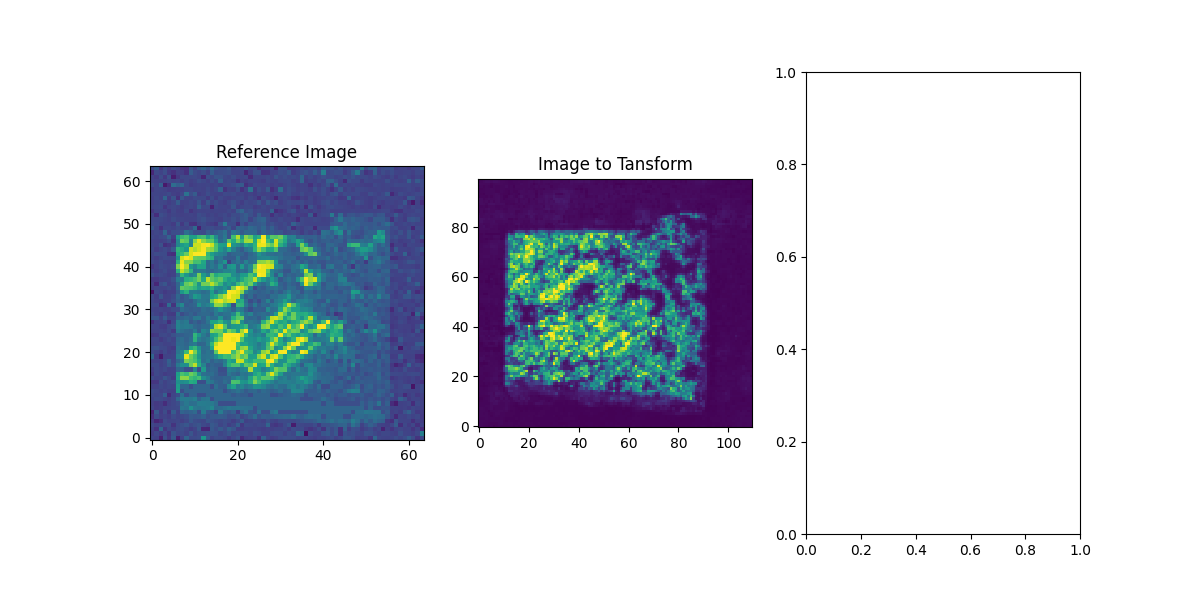

In [215]:
from transform import *

raman_map = scaled_pro_raman[2, find_index(raman_wavelengths, 704.5), :, :]
libs_map = scaled_pro[0, find_index(wavelengths, 610.22), :, :]

%matplotlib widget
aligner = align(raman_map, libs_map, lognorm = False, vmax_l = 0.8, vmax_r = 0.8, weigths = 'nearest', pixel_tol = 1)

# 4. Classification

## 4.1 Raman Features

In [216]:
final_mask_raman = np.transpose(new_data1_raman, axes = (1, 2, 0))

minerals = {
    'Petalite':[491.3],
    'Quartz':[463.92],
    'Spodumene':[704.5],
    'Albite':[508.1],
    'Background':[733.1]}

mineral_list = list(minerals.keys())

features_raman = []
radius = 2

for i,mineral in enumerate(mineral_list):
    wn = find_index(raman_wavelengths,minerals[mineral][0])
    new_array = final_mask_raman[:, :, wn-radius : wn+radius].mean(axis = -1)
    features_raman.append( ( new_array - np.min(new_array) ) / (np.max(new_array) - np.min(new_array)))
    
features_raman = np.transpose(np.array(features_raman), axes = (1, 2, 0))
features_raman = features_raman.reshape([features_raman.shape[0]*features_raman.shape[1], features_raman.shape[2]])

initial_mineral_list = mineral_list

In [217]:
features_raman = np.transpose(features_raman, axes = (1, 0))
features_raman = features_raman.reshape(-1, 64, 64)
f_raman = features_raman

## 4.2 LIBS Features

In [218]:
wl = [460.28, 288.16, 568.77, 237.23]
features_libs = np.array([new_data1[find_index(wavelengths, wl[w])] for w in range(len(wl))])

In [219]:
libs_f = []
features_libs = features_libs.reshape(-1, features_libs.shape[1], features_libs.shape[2])
for i in tqdm(range(4)): 
    aligner.transform(features_libs[i, :, :])
    aligned_map = aligner.new_data
    libs_f.append(aligned_map)
libs_f = np.array(libs_f)

100%|██████████| 4/4 [00:01<00:00,  3.56it/s]


In [220]:
f_raman_cut = np.transpose(f_raman[:, 15:45, 15:50], axes = (1, 2, 0))
f_raman_cut = f_raman_cut.reshape(f_raman_cut.shape[0]*f_raman_cut.shape[1], -1)
f_libs_cut = np.transpose(libs_f[:, 15:45, 15:50], axes = (1, 2, 0))
f_libs_cut = f_libs_cut.reshape(f_libs_cut.shape[0]*f_libs_cut.shape[1], -1)

## 4.3 K-Means Clustering

In [221]:
import sklearn

In [223]:
minerals = {
    'Petalite':[491.3],
    'Quartz':[463.92],
    'Spodumene':[704.5],
    'Albite':[508.1]}

mineral_list = list(minerals.keys())
n_clusters = 4

# Cluster centers already initialized to match those of the predicted features
clusters_init = [ [1,0,0,0,0], 
                 [0,1,0,0,0],
                 [0,0,1,0,0],
                 [0,0,0,1,0]
                ]

model = sklearn.cluster.KMeans(n_clusters=n_clusters, init = np.array(clusters_init), random_state=100)
model.fit(f_raman_cut)
predictions = model.predict(f_raman_cut)

In [224]:
wl = [460.28, 288.16, 237.23, 568.77]
######Li       Si       Al     Na


init=np.array([[1,1,1,0],
               [0,1,0,0],
               [1,1,1,0],
               [0,1,1,1]])
model1 = KMeans(n_clusters = 4, init = init*0.5)

labels_libs = model1.fit_predict(f_libs_cut)

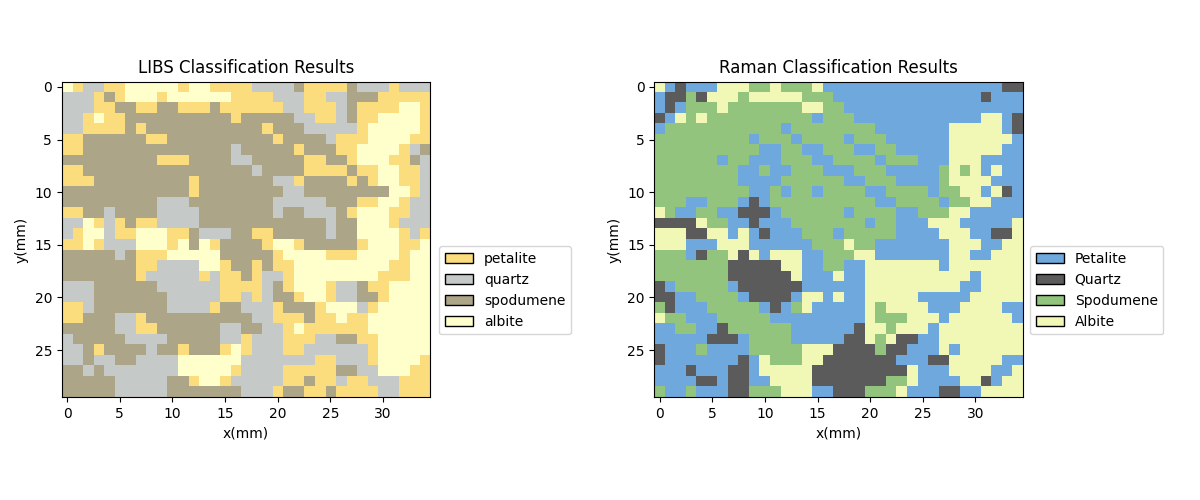

In [225]:
fig, axs = subplots(1, 2, figsize = (12, 5))

ax = axs[0]
nx, ny = 30, 35
colors = ['xkcd:wheat' ,'xkcd:silver','xkcd:stone','xkcd:ecru']
cmp_libs = ListedColormap(colors)
ax.set_xlabel('x(mm)')
ax.set_ylabel('y(mm)')
ax.imshow(labels_libs.reshape(nx, ny)[::, ::], cmap = cmp_libs, interpolation = 'none')
mineral_list2=['petalite','quartz','spodumene','albite']
hls=[]
for color,cluster in zip(colors,mineral_list2):
    patch = mpatches.Patch(color=color, label=cluster,ec='k')
    hls.append(patch)

ax.set_title('LIBS Classification Results')
ax.legend(handles=hls, bbox_to_anchor=(1.4, 0.5))

ax = axs[1]
colors = ['#6fa8dc','#5b5b5b','#93c47d','#F1F7B5']
cmp1 = ListedColormap(colors[:n_clusters])
ax.imshow(predictions.reshape(nx, ny),
           cmap=cmp1,interpolation='nearest')

hls=[]
for color,cluster in zip(colors,mineral_list):
    patch = mpatches.Patch(color=color, label=cluster,ec='k')
    hls.append(patch)

ax.set_title('Raman Classification Results')
ax.legend(handles=hls,bbox_to_anchor=(1.4, 0.5))
ax.set_xlabel(r'x(mm)')
ax.set_ylabel(r'y(mm)')
fig.tight_layout()

# savefig("Images/LIBSvRaman.jpg", dpi = 300)

In [226]:
from sklearn import metrics

libs_confusion = metrics.confusion_matrix(predictions, labels_libs)

In [227]:
libs_confusion = np.array(libs_confusion, dtype = float)
for i in range(libs_confusion.shape[0]):
    libs_confusion[i] /= np.sum(libs_confusion[i])

[Text(0, 0, 'petalite'),
 Text(0, 1, 'quartz'),
 Text(0, 2, 'spodumene'),
 Text(0, 3, 'albite')]

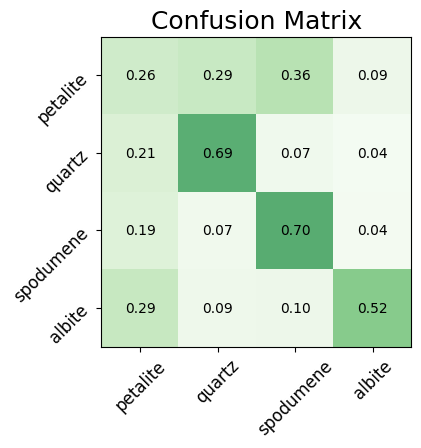

In [229]:
%matplotlib inline
mineral_list2=['petalite','quartz','spodumene','albite']
fig, axs = subplots(1, 1, figsize = (4, 8))
# ax.imshow(libs_confusion, cmap = 'Greens')

ax = axs
ax.set_title('Confusion Matrix', fontsize = 18)
ax.imshow(libs_confusion, cmap = 'Greens', alpha = 0.8, vmin = 0, vmax = 1)
for i in range(libs_confusion.shape[0]):
    for j in range(libs_confusion.shape[1]):
        ax.text(x = j, y = i, s = f'{libs_confusion[i, j]:.2f}', va = 'center', ha = 'center', size = 'medium')

ax.set_xticks([0, 1, 2, 3])
ax.set_yticks([0, 1, 2, 3])
ax.set_xticklabels(mineral_list2, rotation = 45, fontsize = 12)
ax.set_yticklabels(mineral_list2, fontsize = 12, rotation = 45)

# savefig("Images/LIBSvRaman_confusion.jpg", dpi = 300)

# 5. Individual Clustering

In [163]:
cluster_e = []
matrix_conf = []
for energy in range(scaled_pro.shape[0]):
    wl = [460.28, 288.16, 568.77, 237.23]
    features_libs = np.array([scaled_pro[energy, find_index(wavelengths, wl[w]), :, :] for w in range(len(wl))])

    features_libs = features_libs.reshape(-1, features_libs.shape[1], features_libs.shape[2])

    libs_f = []
    for i in tqdm(range(4)): 
        aligner.transform(features_libs[i, :, :])
        aligned_map = aligner.new_data
        libs_f.append(aligned_map)
    libs_f = np.array(libs_f)
    
    f_libs_cut = np.transpose(libs_f[:, 15:45, 15:50], axes = (1, 2, 0))
    f_libs_cut = f_libs_cut.reshape(30*35, -1)

    wl = [460.28, 288.16, 237.23, 568.77]

    init=np.array([[1,1,1,0],
                [0,1,0,0],
                [1,1,1,0],
                [0,1,1,1]])
    model1 = KMeans(n_clusters = 4, init = init)

    labels_libs = model1.fit_predict(f_libs_cut)

    libs_confusion = metrics.confusion_matrix(predictions, labels_libs)
    libs_confusion = np.array(libs_confusion, dtype = float)
    for i in range(libs_confusion.shape[0]):
        libs_confusion[i] /= np.sum(libs_confusion[i])
    
    cluster_e.append(labels_libs)
    matrix_conf.append(libs_confusion)

100%|██████████| 4/4 [00:01<00:00,  3.28it/s]


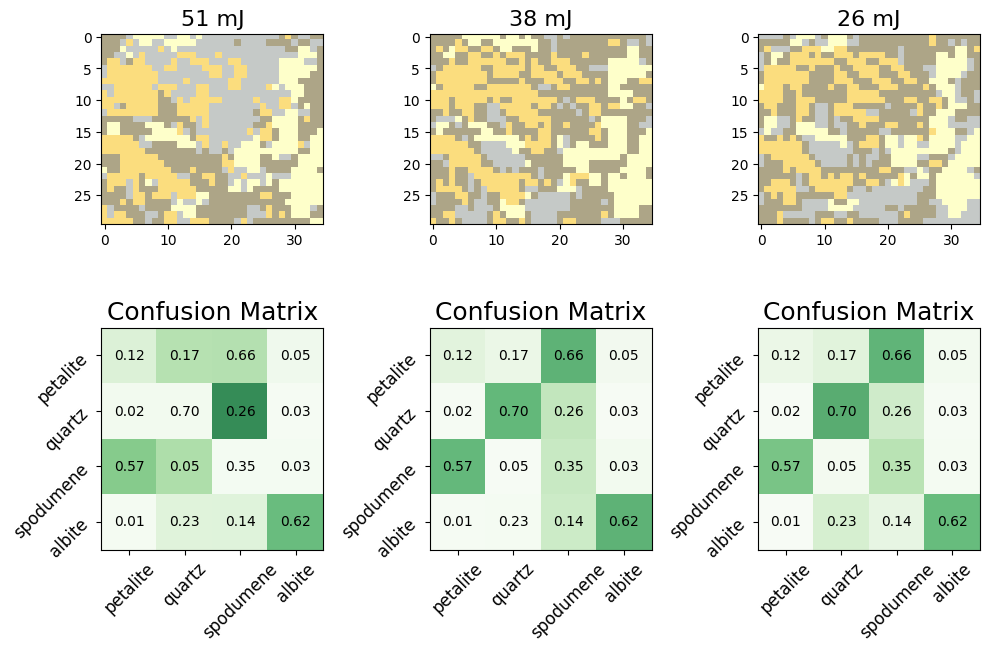

In [164]:
fig, axs = subplots(2, 3, figsize = (10, 7))

ax = axs[0, 0]
ax.imshow(cluster_e[0].reshape(30, 35), cmap = cmp_libs)
ax.set_title("51 mJ", fontsize = 16)

ax = axs[0, 1]
ax.imshow(cluster_e[1].reshape(30, 35), cmap = cmp_libs)
ax.set_title("38 mJ", fontsize = 16)


ax = axs[0, 2]
ax.imshow(cluster_e[2].reshape(30, 35), cmap = cmp_libs)
ax.set_title("26 mJ", fontsize = 16)


ax = axs[1, 0]
ax.set_title('Confusion Matrix', fontsize = 18)
ax.imshow(matrix_conf[0], cmap = 'Greens', alpha = 0.8, vmin = 0, vmax = 1)
for i in range(libs_confusion.shape[0]):
    for j in range(libs_confusion.shape[1]):
        ax.text(x = j, y = i, s = f'{libs_confusion[i, j]:.2f}', va = 'center', ha = 'center', size = 'medium')

ax.set_xticks([0, 1, 2, 3])
ax.set_yticks([0, 1, 2, 3])
ax.set_xticklabels(mineral_list2, rotation = 45, fontsize = 12)
ax.set_yticklabels(mineral_list2, fontsize = 12, rotation = 45)

ax = axs[1, 1]
ax.set_title('Confusion Matrix', fontsize = 18)
ax.imshow(matrix_conf[1], cmap = 'Greens', alpha = 0.8, vmin = 0, vmax = 1)
for i in range(libs_confusion.shape[0]):
    for j in range(libs_confusion.shape[1]):
        ax.text(x = j, y = i, s = f'{libs_confusion[i, j]:.2f}', va = 'center', ha = 'center', size = 'medium')

ax.set_xticks([0, 1, 2, 3])
ax.set_yticks([0, 1, 2, 3])
ax.set_xticklabels(mineral_list2, rotation = 45, fontsize = 12)
ax.set_yticklabels(mineral_list2, fontsize = 12, rotation = 45)

ax = axs[1, 2]
ax.set_title('Confusion Matrix', fontsize = 18)
ax.imshow(matrix_conf[2], cmap = 'Greens', alpha = 0.8, vmin = 0, vmax = 1)
for i in range(libs_confusion.shape[0]):
    for j in range(libs_confusion.shape[1]):
        ax.text(x = j, y = i, s = f'{libs_confusion[i, j]:.2f}', va = 'center', ha = 'center', size = 'medium')

ax.set_xticks([0, 1, 2, 3])
ax.set_yticks([0, 1, 2, 3])
ax.set_xticklabels(mineral_list2, rotation = 45, fontsize = 12)
ax.set_yticklabels(mineral_list2, fontsize = 12, rotation = 45)

fig.tight_layout()

# savefig("Images/solo_enery.jpg", dpi = 300)